In [ ]:
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 訓練資料為one-hot向量時，轉換成正解標籤的索引值
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax的輸出
        self.t = None  # 訓練標籤

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 訓練標籤為one-hot向量時，轉換成正解標籤的索引值        if self.t.size == self.y.size:
        self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid的輸出
        self.t = None  # 訓練資料

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [ ]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化權重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 產生各層
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 把全部的權重與梯度整合成清單
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 在成員變數中，設定字詞的分式散表示
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

In [ ]:
# util
import os
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''計算餘弦相似度
    :param x: 向量
    :param y: 向量
    :param eps: 防止”除以0”的小數值
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''相似詞搜尋
    :param query: 查詢（文本）
    :param word_to_id: 將字詞轉換成字詞ID的字典
    :param id_to_word: 將字詞ID轉換成字詞的字典
    :param word_matrix: 整合詞向量的矩陣。用來儲存對應各列的詞向量    :param top: 要顯示到第幾名為止
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''轉換成one-hot編碼
    :param corpus: 字詞ID清單（一維或二維NumPy陣列）
    :param vocab_size: 語彙量
    :return: one-hot編碼（二維或三為NumPy陣列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''建立共生矩陣
    :param corpus: 語料庫（字詞ID清單）
    :param vocab_size:語彙量
    :param window_size:視窗大小（視窗大小為1時，字詞左右各1個字為上下文）
    :return: 共生矩陣
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''建立PPMI（下一個正向點間互資訊）
    :param C: 共生矩陣
    :param verbose: 是否輸出執行狀況    
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''轉換成one-hot編碼
    :param words: 字詞ID的NumPy陣列
    :param vocab_size: 語彙量
    :return: 轉換成one-hot編碼後的NumPy陣列
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('evaluating perplexity ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 開頭的分隔字元
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 轉換成字串
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [ ]:
# optimizer

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [ ]:
import numpy
import time
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 資料洗牌
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 計算梯度，更新參數
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 把共用的權重整合成一個
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評估
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 計算小批次各個樣本開始載入的位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 計算梯度，更新參數
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 把共用的權重整合成一個
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評估困惑度
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


def remove_duplicate(params, grads):
    '''
    把參數陣列中重複的權重整合成一個，並加上對應該權重的梯度
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 共用權重時
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 加上梯度
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 當作轉置矩陣，共用權重時（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

| epoch 1 |  iter 1 / 53 | time 0[s] | loss 9.33
| epoch 1 |  iter 21 / 53 | time 0[s] | loss 9.33
| epoch 1 |  iter 41 / 53 | time 0[s] | loss 9.33
| epoch 2 |  iter 1 / 53 | time 0[s] | loss 9.33
| epoch 2 |  iter 21 / 53 | time 0[s] | loss 9.33
| epoch 2 |  iter 41 / 53 | time 0[s] | loss 9.33
| epoch 3 |  iter 1 / 53 | time 0[s] | loss 9.33
| epoch 3 |  iter 21 / 53 | time 0[s] | loss 9.32
| epoch 3 |  iter 41 / 53 | time 0[s] | loss 9.32
| epoch 4 |  iter 1 / 53 | time 0[s] | loss 9.32
| epoch 4 |  iter 21 / 53 | time 0[s] | loss 9.32
| epoch 4 |  iter 41 / 53 | time 0[s] | loss 9.32
| epoch 5 |  iter 1 / 53 | time 0[s] | loss 9.32
| epoch 5 |  iter 21 / 53 | time 0[s] | loss 9.31
| epoch 5 |  iter 41 / 53 | time 0[s] | loss 9.31
| epoch 6 |  iter 1 / 53 | time 0[s] | loss 9.31
| epoch 6 |  iter 21 / 53 | time 0[s] | loss 9.30
| epoch 6 |  iter 41 / 53 | time 0[s] | loss 9.29
| epoch 7 |  iter 1 / 53 | time 0[s] | loss 9.29
| epoch 7 |  iter 21 / 53 | time 0[s] | loss 9.28
| epoch

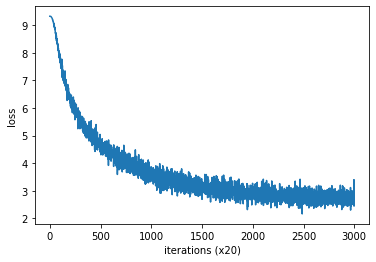

'i'm [ 0.01400918  0.00878476 -0.00322828  0.00840966 -0.0017217 ]
trying [-4.1817484 -3.1802137 -4.483281  -2.5120897  4.7637653]
to [ 3.1851287   2.150847    1.2171171  -0.61937493 -1.9226347 ]
import [ 5.0308757 -1.3628579 -4.3267846 -2.9292376 -1.4332039]
a [ 1.6287633 -2.8591924 -0.694911   0.8301885 -1.3268197]
couple [ 6.8624606  -2.5980675  -0.73666924 -3.897107   -2.0781817 ]
 [ 4.6548696   0.9208628  -3.8095005   0.96339595  0.23043989]
.txt [ 9.089956  -4.453874   4.0250916 -0.5578478  4.45564  ]
files [ 4.0735574   1.3905191  -1.8951261   0.72291875  2.043893  ]
into [2.4078965 0.0318818 4.600754  1.5131798 6.596192 ]
colab [ 0.626635    0.77169144 -2.3126433   1.2535739   1.5764313 ]
from [1.2667427 3.269978  1.027046  3.282668  4.5130167]
my [-0.97628725 -2.712341   -1.0951556   0.8130689   4.5024586 ]
own [-0.2974663   3.3547652  -0.62438947  3.265716    2.6518886 ]
google [-3.466218    2.5698671  -0.59154266  3.0008552   0.38955835]
drive [ 1.8396447 -0.2576252 -4.03807

In [ ]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = ''''I'm trying to import a couple .txt files into Colab from my own Google Drive. The colab notebook I'm using is in the same folder as the files I want to upload within that notebook. While there is documentation on file I/O on External data: Local Files, Drive, Sheets, and Cloud Storage within Colab, the descriptions do not seem to fit what I'm looking for (e.g. I could upload these files directly from my local directory each time I use the notebook, but instead, I would like to have a cell written that loads them once and keeps them loaded via a connection to my own Drive). Also, the .txt files I want to upload contain samples of plain text to use for training a deep learning algorithm on sentiment analysis, and thus does not appear to be convertable to a .csv for functionally equivalent application (which might be solved by Google Sheets).'''
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])